# Problema de Negócio:

* A Vale S.A. (VALE3) é uma das principais empresas de mineração listadas na B3, com forte impacto no portfólio de investidores institucionais e pessoa física no Brasil. Para um gestor de investimentos ou analista de mercado, antecipar a trajetória do preço de fechamento (Close) e entender os padrões de volume de negociação é crucial para:

    1. Tomar decisões de compra/venda com melhor relação risco-retorno;

    2. Ajustar a alocação de ativos de curto a médio prazo;

    3. Desenvolver estratégias de trading baseadas em sinais estatísticos e de machine learning;

    4. Gerenciar o risco por meio de previsões confiáveis e métricas de incerteza.

* Objetivo Geral:
Desenvolver um modelo preditivo de séries temporais para o preço de fechamento diário de VALE3, de modo a gerar forecasts de 30 a 90 dias futuros e embasar decisões de investimento.

* Importando as bibliotecas necessárias: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from prophet import Prophet
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

# 1. Análise exploratória e tratamento de dados:

* Coleta de dados:

In [2]:
# Primeiramente, vamos importar a base de dados que contém os preços das ações da Vale S.A:
# Vamos baixar as ações da Vale S.A:
vale = yf.download('VALE3.SA', start='2018-01-01', end='2024-12-31', multi_level_index=False)
vale = vale[['Close', 'Open']]
vale = vale.reset_index()
vale['Date'] = pd.to_datetime(vale['Date'])
vale.set_index('Date', inplace=True)
vale

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Close,Open
Date,,
2018-01-02,24.608639,23.853626
2018-01-03,24.461174,24.673521
2018-01-04,24.561445,24.661721
2018-01-05,24.944853,24.520158
2018-01-08,25.499313,25.009737
...,...,...
2024-12-20,52.568302,51.413377
2024-12-23,52.789661,52.616422
2024-12-26,52.943653,52.789663


* Vamos fazer uma descrição dos dados:

In [3]:
vale.describe()

,Close,Open
count,1738.000000,1738.000000
mean,49.727550,49.778886
std,16.802999,16.826880
min,21.242062,22.145317
25%,31.648945,31.685356
50%,55.730608,55.742268
75%,61.646538,61.733465
max,81.999199,81.873684


* Vamos visulizar os dados com ajuda de um boxplot:

Text(0.5, 1.0, 'Boxplot dos preços de fechamento e abertura da VALE3.')

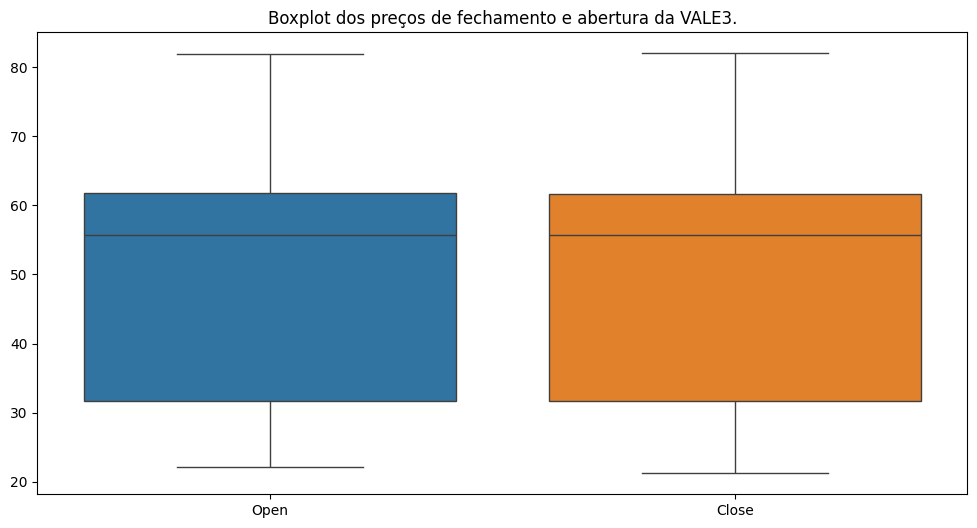

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(data=vale[['Open','Close']])
plt.title('Boxplot dos preços de fechamento e abertura da VALE3.')

* Podemos observar no boxplot dos preços de fechamento e abertura das ações da VALE3:

1. Ambos os valores, fechamento e abertura, apresentam variação entre R$ 20 e R$ 80 reais.

2. As distribuições de Open e Close são parecidas, indicando que os preços de abertura e fechamento da VALE3 costumam ser próximos no mesmo dia.

* Detalhamento por variável:

    🟦 Open (Abertura):
    * Mediana: ~ R$55 reais 
    * 1° Quartil: ~ R$30 reais
    * 2° Quartil: ~ R$60 reais 
    * A caixa(entre Q1 e Q3) apresenta maior concentração de preços.
    * A dispersão é grande, mas sem outliers visíveis.

    🟧 Close (Fechamento):
    * Mediana: também em torno de R$ 55 reais, muito próxima da de Open.

    * Faixa interquartil também parecida.

    * Os extremos mínimo e máximo (sem outliers) indicam que os fechamentos seguem uma dinâmica parecida com as aberturas.  

* Agora vamos agrupar as ações por meses e anos:

In [5]:
# Média mensal para suavização ou input em modelos preditivos:
df_acoes_anos = vale[['Close', 'Open']].resample('Y').mean()
df_acoes_anos['Variação'] = df_acoes_anos['Close'].pct_change() * 100
df_acoes_anos['Variação'] = df_acoes_anos['Variação'].fillna(0)
df_acoes_anos

/tmp/ipykernel_6524/2724628001.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_acoes_anos = vale[['Close', 'Open']].resample('Y').mean()


,Close,Open,Variação
Date,,,
2018-12-31,29.824469,29.835262,0.000000
2019-12-31,29.859930,29.895998,0.118899
2020-12-31,36.138908,36.125757,21.028108
2021-12-31,66.443034,66.544301,83.854568
2022-12-31,64.464207,64.481961,-2.978231
2023-12-31,63.619808,63.727753,-1.309872
2024-12-31,57.437278,57.535532,-9.717933


In [6]:
# Média mensal para suavização ou input em modelos preditivos:
df_acoes_meses = vale[['Close', 'Open']].resample('M').mean()
df_acoes_meses['Retorno_Mensal'] = df_acoes_meses['Close'].pct_change() * 100
df_acoes_meses['Retorno_Mensal'] = df_acoes_meses['Retorno_Mensal'].fillna(0)
df_acoes_meses

/tmp/ipykernel_6524/1354041635.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_acoes_meses = vale[['Close', 'Open']].resample('M').mean()


,Close,Open,Retorno_Mensal
Date,,,
2018-01-31,24.955577,24.934127,0.000000
2018-02-28,26.067865,26.009207,4.457073
2018-03-31,24.971254,25.013948,-4.206754
2018-04-30,26.951192,26.788280,7.928868
2018-05-31,30.567268,30.494800,13.417128
...,...,...,...
2024-08-31,54.930459,55.038437,-3.840691
2024-09-30,56.021609,56.147890,1.986420
2024-10-31,58.904311,58.925049,5.145697


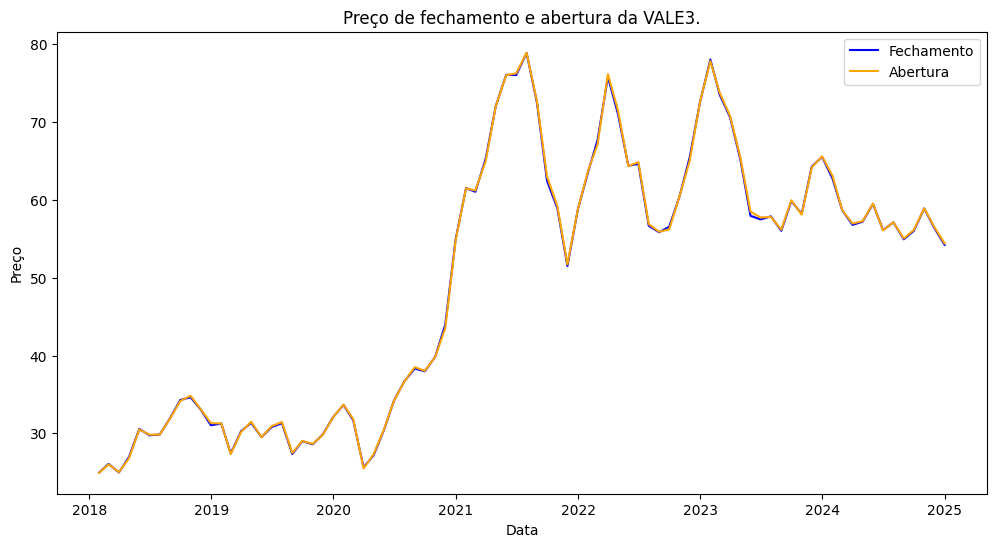

In [11]:
# Vamos visualizar o comportamento mensal das ações da VALE3 com um gráfico de linha:
plt.figure(figsize=(12,6))
plt.plot(df_acoes_meses['Close'], label='Fechamento', color='blue')
plt.plot(df_acoes_meses['Open'], label='Abertura', color='orange')
plt.title('Preço de fechamento e abertura da VALE3.')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()

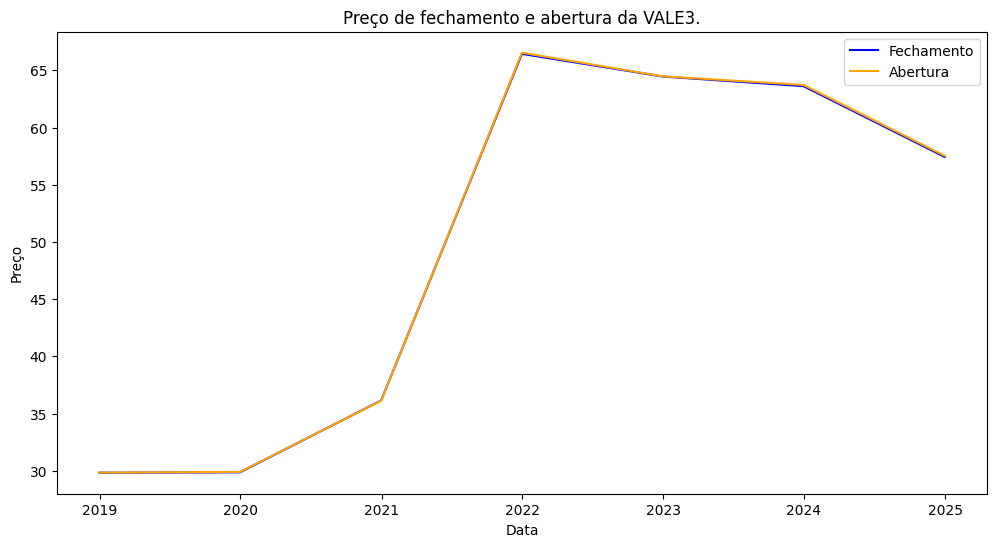

In [12]:
# Vamos visualizar o comportamento anual das ações da VALE3 com um gráfico de linha:
plt.figure(figsize=(12,6))
plt.plot(df_acoes_anos['Close'], label='Fechamento', color='blue')
plt.plot(df_acoes_anos['Open'], label='Abertura', color='orange')
plt.title('Preço de fechamento e abertura da VALE3.')
plt.xlabel('Data')
plt.ylabel('Preço')
plt.legend()
plt.show()

* O que podemos extrair de insights das ações da Vale S.A entre 2018 a 2024?

1. Fase de crescimento(2018 - 2021):
    * A demanda por minério de ferro apresentou uma tendência geral de crescimento entre 2018 e 2021, apesar de algumas flutuações. Inicialmente, houve uma queda entre 2018 e 2020, impulsionada em parte pela pandemia de COVID-19, mas a demanda retomou a trajetória de crescimento em 2021. A China, como maior consumidora global, teve um papel crucial neste crescimento, puxando a demanda e os preços do minério de ferro.
    Isso explica o porque, mesmo com uma pandemia ocorrendo no Brasil, entre 2019 e 2021 as ações da Vale S.A tiveram uma valorização de até 83%.

2. Fase de correção(2022 - 2024):
    * A partir de 2022, a ação entrou em uma tendência de queda, com variações negativas consecutivas: -2.98% (2022), -0.98% (2023) e -7.24% (2024). Isso sugere uma correção após o pico de 2021, com a queda mais acentuada em 2024.
    Outros fatores importantes são: a queda no preço das commodities de ferro e a volatilidade financeira nos mercados globais.

3. Volatilidade:
    * A ação demonstra alta volatilidade ao longo do período, com variações extremas em 2021 (crescimento de 83.85%) e 2024 (queda de 7.24%). Isso indica que a VALE3 é sensível a mudanças no mercado ou eventos específicos.


4. Relação entre Close e Open:
    * Em todos os anos, os preços de abertura e fechamento são muito próximos dentro de cada ano. Isso sugere que as grandes variações percentuais ocorreram ao longo dos meses, e não entre o último dia de um ano e o primeiro dia do ano seguinte.


# 2. Visualização de Tendências e Sazonalidades: 

* Vamos plotar um gráfico de linha com médias móveis, para vermos como o preço de fechamento das ações se comportou:

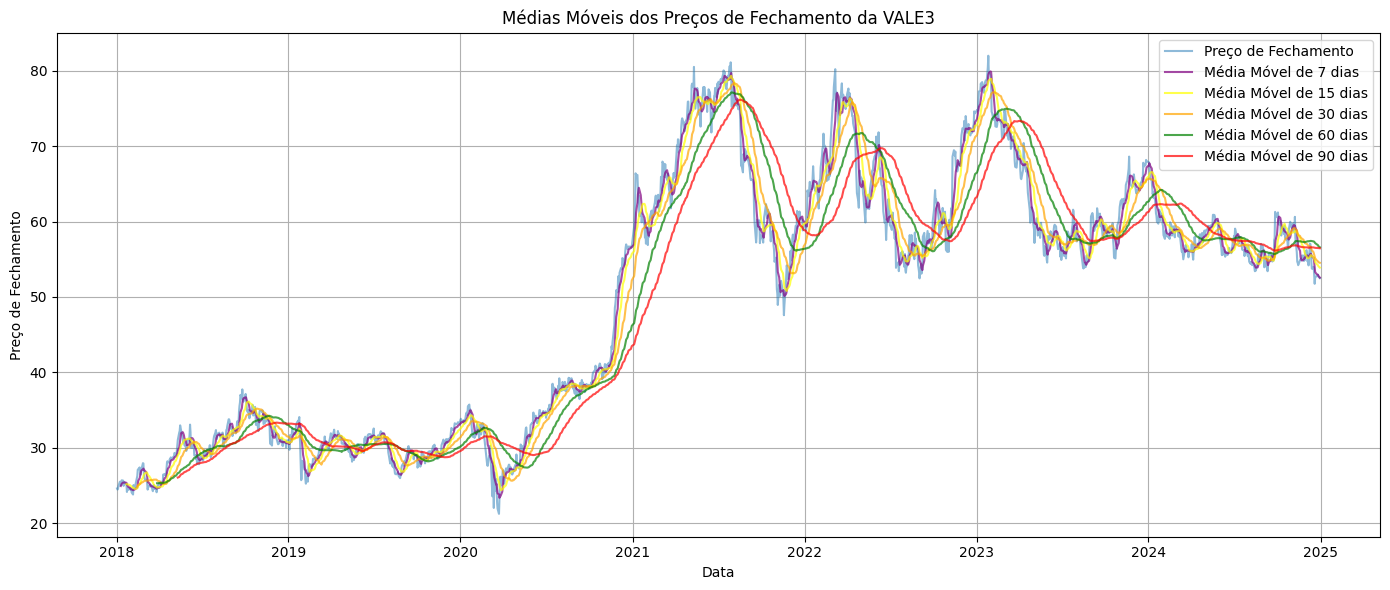

In [8]:
plt.figure(figsize=(14,6))
plt.plot(vale['Close'], label='Preço de Fechamento',alpha=0.5)
plt.plot(vale['Close'].rolling(window=7).mean(), label='Média Móvel de 7 dias', color='purple', alpha=0.7)
plt.plot(vale['Close'].rolling(window=15).mean(), label='Média Móvel de 15 dias', color='yellow', alpha=0.7)
plt.plot(vale['Close'].rolling(window=30).mean(), label='Média Móvel de 30 dias', color='orange', alpha=0.7)
plt.plot(vale['Close'].rolling(window=60).mean(), label='Média Móvel de 60 dias', color='green', alpha=0.7)
plt.plot(vale['Close'].rolling(window=90).mean(), label='Média Móvel de 90 dias', color='red', alpha=0.7)
plt.title('Médias Móveis dos Preços de Fechamento da VALE3')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Resumo da Análise: Médias Móveis da VALE3  

## **Principais Insights**  
1. **Tendências Temporais**  
   - **Curto Prazo (7-15 dias)**: Alta volatilidade, reagindo a eventos de mercado.  
   - **Longo Prazo (60-90 dias)**: Indicam tendências macro (ex: bull market se ascendente).  

2. **Sinais Estratégicos**  
   - **Golden Cross** (média curta > média longa): Sinal de compra (ex: recuperação pós-COVID em 2020).  
   - **Death Cross** (média curta < média longa): Sinal de venda (ex: crises abruptas).  

3. **Volatilidade**  
   - Distância entre médias revela períodos de alta oscilação (ex: 2020–2021) ou consolidação (ex: 2023).  

4. **Eventos Externos**  
   - Queda em 2020 (pandemia), pico em 2021–2022 (alta de commodities), e possível estabilização em 2024–2025.  



# 3. Vamos aplicar o modelo Prophet:

18:31:42 - cmdstanpy - INFO - Chain [1] start processing
18:31:44 - cmdstanpy - INFO - Chain [1] done processing


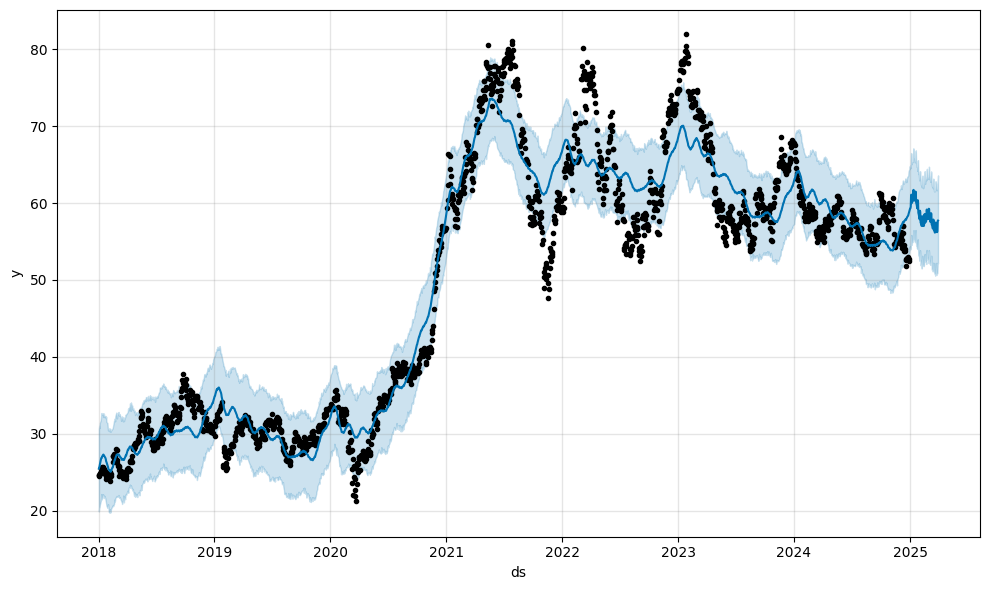

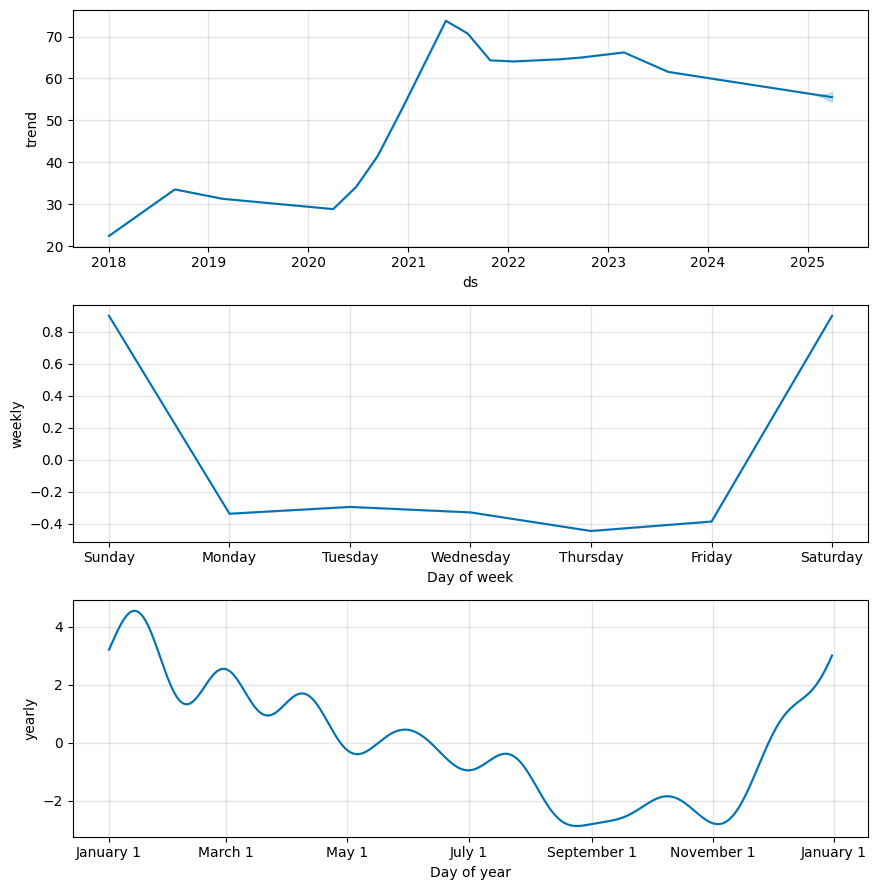

In [13]:
# Criando um DataFrame com os preços de fechamento:
vale_df = vale[['Close']].reset_index()
vale_df = vale_df.rename(columns={'Date': 'ds', 'Close': 'y'})
vale_df['ds'] = pd.to_datetime(vale_df['ds'])

# Criando o modelo Prophet:
m = Prophet()
m.fit(vale_df)

# Criando um DataFrame para prever os próximos 90 dias:
future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)

# Visualizando as previsões:
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)
plt.show()

* Validação do modelo e visualização das previsões:

MAPE: 6.48
MAE: 3.17
R²: 0.94


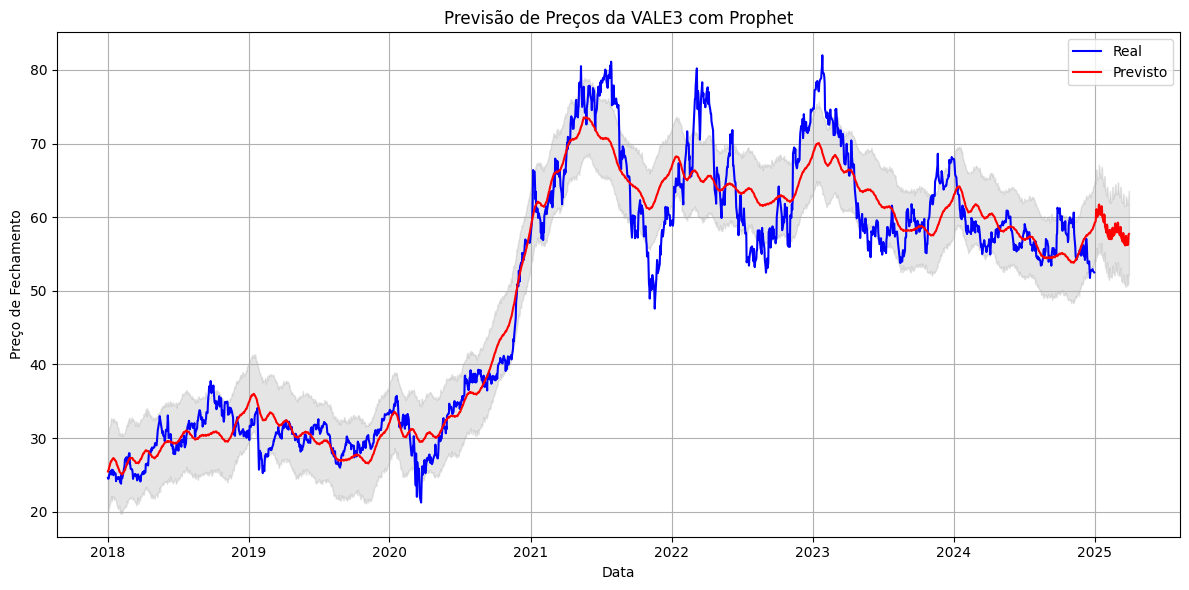

In [ ]:
# Validação do modelo com MAPE, MAE e R²:
MAPE = mean_absolute_percentage_error(vale_df['y'], forecast['yhat'][:len(vale_df)]) * 100
MAE = mean_absolute_error(vale_df['y'], forecast['yhat'][:len(vale_df)])
R2 = r2_score(vale_df['y'], forecast['yhat'][:len(vale_df)])
print(f'MAPE: {MAPE:.2f}%')
print(f'MAE: {MAE:.2f}')
print(f'R²: {R2:.2f}')

# Visualizando os dados reais e previstos:
plt.figure(figsize=(12,6))
plt.plot(vale_df['ds'], vale_df['y'], label='Real', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Previsto', color='red')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2)
plt.title('Previsão de Preços da VALE3 com Prophet')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()